Notes:
 * final curated dataset

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/extended_22_run_13'
data_files = '/mnt/tess/astronet/tfrecords-22-train/*'
tces_file = '/mnt/tess/astronet/tces-v5-train.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/extended_22_run_13/1/AstroCNNModel_extended_20210123_230247',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/2/AstroCNNModel_extended_20210123_233704',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/3/AstroCNNModel_extended_20210124_001135',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/4/AstroCNNModel_extended_20210124_004519',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/5/AstroCNNModel_extended_20210124_011920',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/6/AstroCNNModel_extended_20210124_015336',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/7/AstroCNNModel_extended_20210124_022808',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/8/AstroCNNModel_extended_20210124_030218',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/9/AstroCNNModel_extended_20210124_033541',
 '/mnt/tess/astronet/checkpoints/extended_22_run_13/10/AstroCNNModel_extended_20210124_040845']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 2
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 3
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 4
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 5
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 7
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 8
Binary prediction threshold: 0.2152499407880693 (orientative)
17872 records
Running model 9
Binary prediction threshold: 0.2152499407880693 (orientative)
3292 records

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
labels = ['disp_E', 'disp_N', 'disp_J', 'disp_S', 'disp_B']

col_e = labels.index('disp_E')
thresh = config.hparams.prediction_threshold
thresh = 0.95

In [24]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_E')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [25]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [26]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [27]:
ppos = (pl['disp_E_p'] > 0)
pos = (pl['disp_E'] > 0)

pneg = (pl['disp_E_p'] == 0)
neg = (pl['disp_E'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9472851871375857
Precision: 0.9692556634304207


In [8]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

379464439
381366555
383390727
383390914
383716793
389013422
389364577
394232334
404797784
404853708
405952536
409651781
409851100
114053589
118324224
120397217
129036837
141029164
169316288
444043522
310004006
387829772
288346083
298734307
298757219
179308589
182894670
183073148
200135791
201635971
238183537
260472863
261262721
357046804
266676103
286330326
286405674
306059878
409726763
81749728
87593814
30639928
306511505
309434156
31532677
322284851
325339373
339600659
425064757
425561347
446523110
49137560
56773241
85765877
268608949
272178884
272181655
279021812
428404278
92328347
115684219
136971594
289236608
358715557
293346794
293664120
294092966
294871044
300405121
306103891
343452418
364112579
364951842
369860950
373849740
376936788
198410480
277015008
277123828
277316602
279958090
287156968
321915222
326974824
202489696
27491137
305876160
420115946
176551075
186400565
26516151
306263608
57919833
96785948
138588540
138618351
142748406
332146607
356630364
154068411


In [28]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

384077498
389363745
404768904
404851226
101654574
119384992
179308949
180416902
220375993
25078924
261136311
377197068
239814191
267694283
309682332
414897731
445706410
31415158
31634175
424879951
456588598
464488581
49449799
50308490
79655149
88353444
233896030
329704753
378275445
43667308
91001369
40993256
420177694
117631084
290605311
29984021
301896004
30193373
302965287
304864057
306108833
340217291
349154278
349373192
370134610
370227480
373840212
373843852
137501278
276793626
277022748
277027632
279957439
326919774
445417446
18252911
229751802


In [29]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 249951802)

,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,
249951802,0.001862,0.169899,0.995803,0.001255,0.001149
249951802,0.000638,0.094291,0.997986,0.000905,0.001699
249951802,0.000130,0.099938,0.999345,0.000533,0.001904
249951802,0.000681,0.098082,0.997602,0.001844,0.002561
249951802,0.000340,0.101546,0.999083,0.000228,0.000819
249951802,0.000137,0.088219,0.999473,0.000230,0.001337
249951802,0.001828,0.154869,0.996766,0.000317,0.001720
249951802,0.000279,0.097821,0.999276,0.000281,0.001417
249951802,0.000802,0.113184,0.997519,0.000557,0.001394


In [20]:
pl[pl.index == 404220255]

,disp_E_p,disp_N_p,disp_J_p,disp_S_p,disp_B_p,maxcount,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,,,,,,,


### PR curve

In [12]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_E']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [13]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.991186434154996, max R: 1.0, max P: 1.0
100% recall at: 68%, threshold: 0.06200000000005468


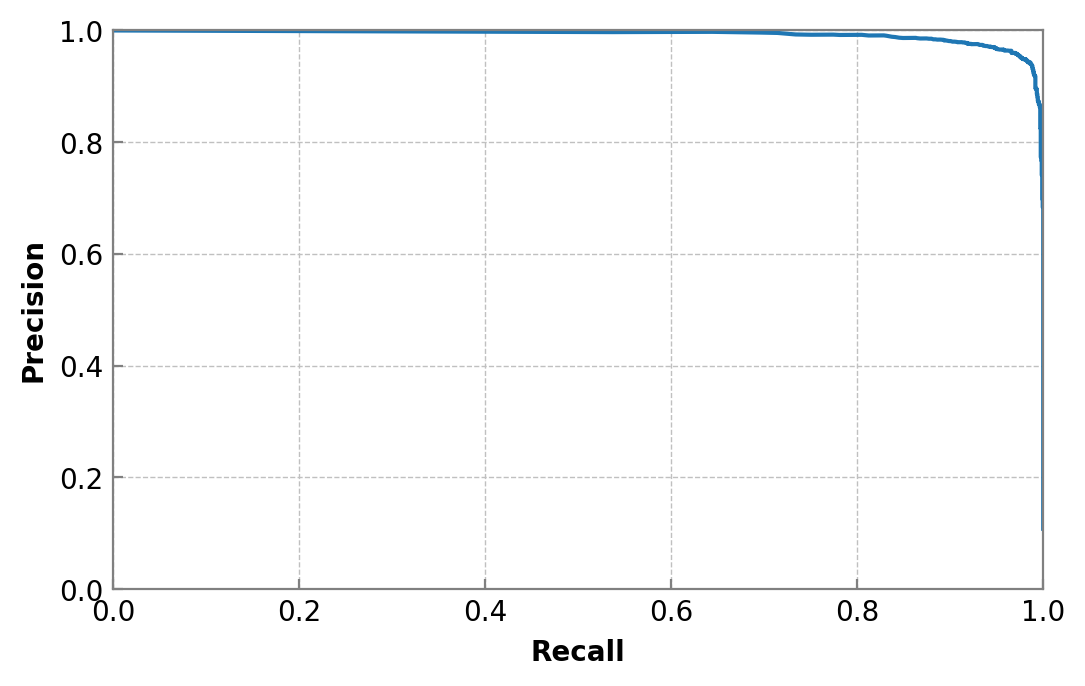

In [14]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)